/var/folders/n4/p2lmf2l94x3gfqhs72xx2zwr0000gn/T/ipykernel_50261/2733567392.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Longest Quiet Streak: 29 days
Longest Noise Streak: 6 days


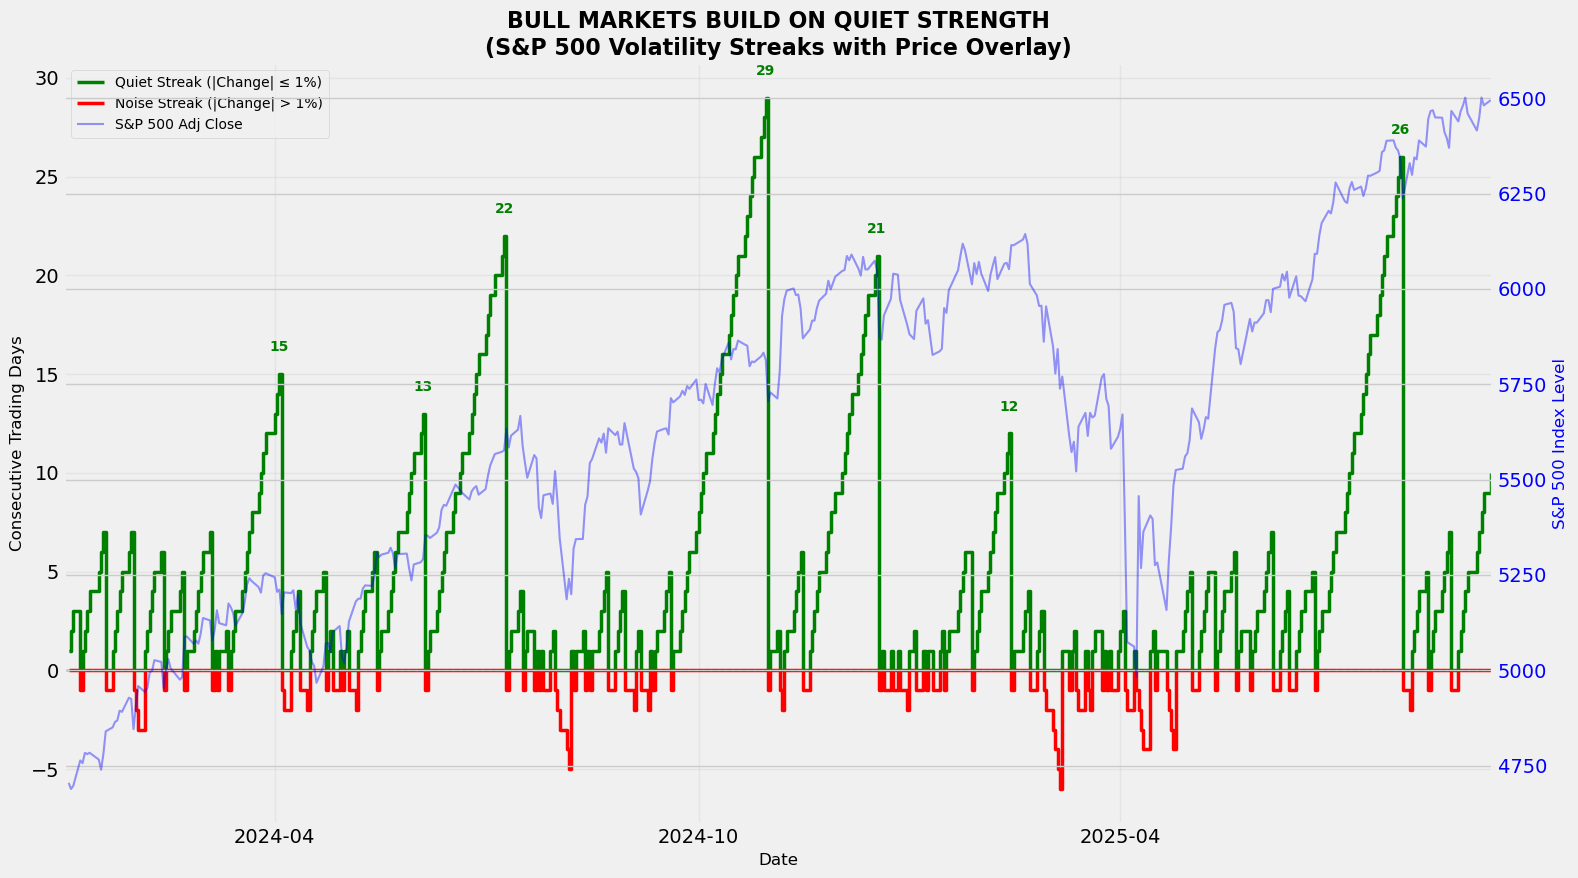

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Set a clean plot style
plt.style.use('fivethirtyeight')

# Step 1: Fetch S&P 500 data
start_date = '2024-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # Up to current date (e.g., 2025-07-26)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500['Close'] = sp500['Close']  # Use adjusted close for accuracy in dividends/splits

# Step 2: Compute daily % change
sp500['Pct_Change'] = sp500['Close'].pct_change() * 100  # In percent
sp500['Abs_Pct_Change'] = np.abs(sp500['Pct_Change'])
sp500 = sp500.dropna()  # Drop first row with NaN

# Step 3: Compute streaks (treat exactly 1% as quiet for simplicity)
quiet_streak = []
noise_streak = []
current_quiet = 0
current_noise = 0

for change in sp500['Abs_Pct_Change']:
    if change <= 1:
        current_quiet += 1
        current_noise = 0
        quiet_streak.append(current_quiet)
        noise_streak.append(0)
    else:  # >1
        current_noise += 1
        current_quiet = 0
        quiet_streak.append(0)
        noise_streak.append(-current_noise)

sp500['Quiet_Streak'] = quiet_streak
sp500['Noise_Streak'] = noise_streak

# Compute some meaningful stats (longest streaks)
max_quiet = sp500['Quiet_Streak'].max()
max_noise = -sp500['Noise_Streak'].min()  # Positive value
print(f"Longest Quiet Streak: {int(max_quiet)} days")
print(f"Longest Noise Streak: {int(max_noise)} days")

# Step 4: Plot the chart (focusing on quiet/noise with improvements)
fig, ax = plt.subplots(figsize=(16, 9))

# Plot quiet (green, positive) and noise (red, negative) as step lines for clearer streak visualization
ax.step(sp500.index, sp500['Quiet_Streak'], where='post', color='green', label='Quiet Streak (|Change| ≤ 1%)', linewidth=2.5)
ax.step(sp500.index, sp500['Noise_Streak'], where='post', color='red', label='Noise Streak (|Change| > 1%)', linewidth=2.5)

# Add horizontal line at 0 for separation
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

# Add secondary axis for S&P 500 price context (makes data more meaningful)
ax2 = ax.twinx()
ax2.plot(sp500.index, sp500['Close'], color='blue', alpha=0.4, label='S&P 500 Adj Close', linewidth=1.5)
ax2.set_ylabel('S&P 500 Index Level', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Add titles and labels
ax.set_title('BULL MARKETS BUILD ON QUIET STRENGTH\n(S&P 500 Volatility Streaks with Price Overlay)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Consecutive Trading Days', fontsize=12)
ax.grid(True, alpha=0.3)

# Customize x-axis (major ticks every 6 months, better formatting)
ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Annotate streak peaks only (at the end of each streak, if above threshold)
annotation_threshold = 10  # Annotate streaks longer than this
for i in range(len(sp500)):
    # Quiet peaks
    if sp500['Quiet_Streak'].iloc[i] > 0 and (i == len(sp500) - 1 or sp500['Quiet_Streak'].iloc[i + 1] == 0):
        val = sp500['Quiet_Streak'].iloc[i]
        if val > annotation_threshold:
            ax.text(sp500.index[i], val + 1, str(int(val)), color='green', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Noise peaks
    if sp500['Noise_Streak'].iloc[i] < 0 and (i == len(sp500) - 1 or sp500['Noise_Streak'].iloc[i + 1] == 0):
        val = sp500['Noise_Streak'].iloc[i]
        if -val > annotation_threshold:
            ax.text(sp500.index[i], val - 1, str(int(-val)), color='red', ha='center', va='top', fontsize=10, fontweight='bold')

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()